In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Style transfer

In [2]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage
# torch.cuda.set_device(3)

# torch.backends.cudnn.benchmark=True

In [3]:
PATH = Path('data/imagenet-sample')
PATH_TRN = PATH/'train'

In [4]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

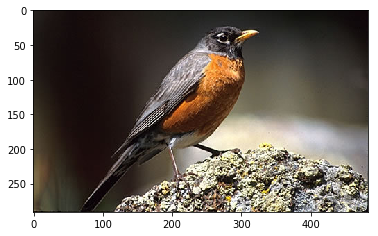

In [5]:
img_fn = PATH_TRN/'n01558993'/'n01558993_9684.JPEG'
img = open_image(img_fn)
plt.imshow(img);

In [6]:
sz=288

In [7]:
trn_tfms,val_tfms = tfms_from_model(vgg16, sz)
img_tfm = val_tfms(img)    # can be called as a function -> transformed image
img_tfm.shape              # channel first; squared HxW; normalized (0 mean, 1 std)

(3, 288, 288)

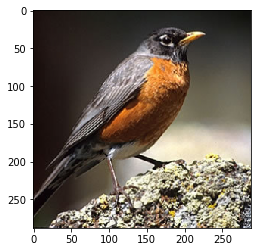

In [17]:
# how to display denormalized img_tfm
plt.imshow(val_tfms.denorm(np.rollaxis(img_tfm,0,3)))

** Style Transfer Loss Function **  
Inputs: picture of bird (content), van gogh painting (style), initial image (noise)
Output: Value which decreases as the initial image looks like the bird painted by van gogh
 - content loss: similarity to the bird
 - style loss: similarity to van gogh 
 
Content Loss -> could use Mean Squared Error to generate a replica of our input content (see Replicate Image from noise via MSE)  
but any function we use for our style loss will automatically increase our content loss (changing pixel values)   
instead we use perceptual loss - loss compared with an activation layer (instead of pixels) -> similar semantics but not exactly the same pixel values


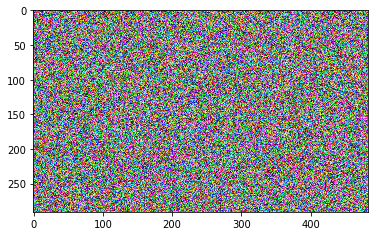

In [44]:
# Initial image - Instead of updating model weights, we'll instead update these pixel values via backprop
opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
plt.imshow(opt_img);

In [45]:
opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])
# using median filter (median pooling) to blur image -> add more smoothness

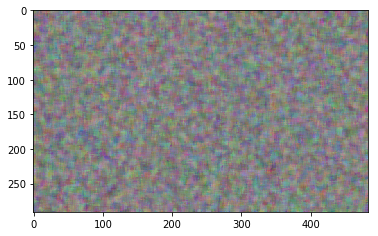

In [46]:
plt.imshow(opt_img);

In [47]:
opt_img = val_tfms(opt_img)/2
# bird image had mean about half of the noise image (hence /2)
opt_img_v = V(opt_img[None], requires_grad=True)
# turn into variable w/ requires grad=True b/c we're transforming this image
# slicing w/ [None] (same as np.newaxis) => introduces a new unit axis; equivalently a minibatch of size 1
opt_img_v.shape

torch.Size([1, 3, 288, 288])

In [24]:
m_vgg = nn.Sequential(*children(m_vgg)[:37])
# we're using the 37th layer of vgg as our activations for the perceptual loss
# creates a subset of vgg which outputs this layer

In [25]:
targ_t = m_vgg(VV(img_tfm[None]))  # VV -> turns into variable but don't need gradients
# gives us the 37th layer of target activations
# slicing w/ [None] (same as np.newaxis) => introduces a new unit axis; equivalently a minibatch of size 1
targ_v = V(targ_t)
targ_t.shape

torch.Size([1, 512, 18, 18])

In [26]:
max_iter = 1000
show_iter = 100
optimizer = optim.LBFGS([opt_img_v], lr=0.5)
# Limited memory BFGS

# Gradient of loss (how fast does the function change?) and 2nd Derivative (how fast does the gradient change?)
# *in higher dimensions: gradient = 'Jacobian'; 2nd derivative = 'Hessian'
# adjust jumps according to 2nd derivative (shallow -> big jumps; steep -> small jumps)

# BFGS - usually not a good idea because the number of hessian calculations grows exponentially w/ dimensionality
# better to take a few steps, see how much jacobian (gradient) is changing -> approximate the hessian
# L-BFGS - keeping track of all the steps takes lots of memory; only keep last 10 or 20...

# LBFGS usually doesn't make sense for NNs -> leads to saddle points
# in this scenario we're not optimizing weights, we're optimizing pixels -> works quicker than SGD here

In [27]:
def actn_loss(x): return F.mse_loss(m_vgg(x), targ_v)*1000

# *multiply by 1000 here but why?
# single precision floating point isn't super precise
# small gradients and small lr updates results in a small number; so small it gets rounded to 0...

# multiplier here not important.  We only care about direction and relative size.  Decrease loss quickly.

In [28]:
def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter+=1
    if n_iter%show_iter==0: print(f'Iteration: {n_iter}, loss: {loss.data[0]}')
    return loss

In [19]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,actn_loss))

Iteration: n_iter, loss: 0.8466196656227112
Iteration: n_iter, loss: 0.34066855907440186
Iteration: n_iter, loss: 0.21001280844211578
Iteration: n_iter, loss: 0.15562333166599274
Iteration: n_iter, loss: 0.12673595547676086
Iteration: n_iter, loss: 0.10863320529460907
Iteration: n_iter, loss: 0.0966048613190651
Iteration: n_iter, loss: 0.08812198787927628
Iteration: n_iter, loss: 0.08170554041862488
Iteration: n_iter, loss: 0.07657770067453384


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


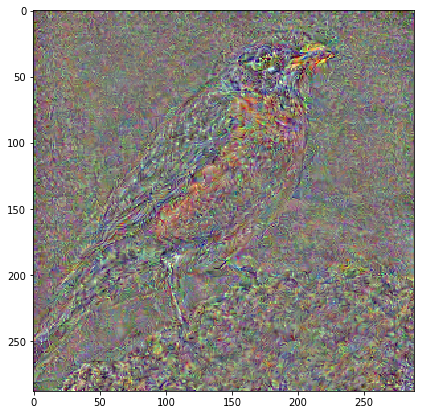

In [22]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]  #=> torch.Size([1, 512, 18, 18])
# roll axis 1 back to 4th position and index into the first => ([18, 18, 512])
plt.figure(figsize=(7,7))
plt.imshow(x);

## forward hook

It'd be nice to get access to different (or multiple) activation layers (instead of simply lopping off the end like above)  
forward hook -> plug into forward pass of a calculation  
backward hook -> plug into backward pass

In [63]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
        # when the forward method of this module (m) is called it will call self.hook_fn
    def hook_fn(self, module, input, output): self.features = output
        # stores output in the features attribute
    def close(self): self.hook.remove()

In [49]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)
# don't waste time/memory calculating gradients

In [50]:
# find all the layers before maxpool layers -> typically the best representation available at that grid size
block_ends = [i-1 for i,o in enumerate(children(m_vgg)) if isinstance(o,nn.MaxPool2d)]
block_ends

[5, 12, 22, 32, 42]

In [64]:
sf = SaveFeatures(children(m_vgg)[block_ends[3]])   # getting 32nd layer as module
# every forward pass, the 32nd layer's output will be stored in sf.features

In [67]:
# same as above but organized into a function
def get_opt():
    opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)  # noise
    opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])       # smoothed
    opt_img_v = V(val_tfms(opt_img/2)[None], requires_grad=True)          # equalize mean, variable w/ grad
    return opt_img_v, optim.LBFGS([opt_img_v])

In [68]:
opt_img_v, optimizer = get_opt()

In [54]:
m_vgg(VV(img_tfm[None]))         # calls forward on the vgg network (we're throwing away the output)
targ_v = V(sf.features.clone())  # grabbing the features we stored w/ the forward hook
targ_v.shape

torch.Size([1, 512, 36, 36])

In [75]:
def actn_loss2(x):
    m_vgg(x)              # calls forward on network and doesn't save results
    #out = V(sf.features)  # chosen layer activations => error: variable does not require grad and does not have a grad_fn
    #out = V(sf.features, requires_grad=True)  # this avoids error but results in no drop in loss...
    out = sf.features  # remove variable to avoid above error and still optimize
    return F.mse_loss(out, targ_v)*1000

In [ ]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,actn_loss2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


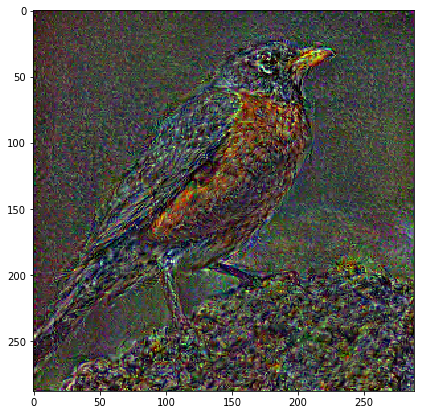

In [43]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
x=np.clip(x,0,1)
plt.imshow(x);

Earlier activation layer looks better -> closer to actual pixel values 

In [58]:
sf.close()

## Style match

Similar to above we'll take an activation layer of the style source.  But without spatial context.  
=> flatten channels and take the dot product btw channels => one number (measure of correlation btw channels)
 - different channels - how the channels are correlated
 - one channel w/ self - (2 norm, sum over squares) how much that channel is represented in the image  

gram matrix - flatten out all of the channels and calculate a dot product for all of the possibilities  
=> n_channel x n_channel matrix
- non-spatial representation of how channels correlate w/ each other

In [73]:
style_fn = PATH/'style'/'starry_night.jpg'

In [74]:
style_img = open_image(style_fn)
style_img.shape, img.shape

((1198, 1513, 3), (291, 483, 3))

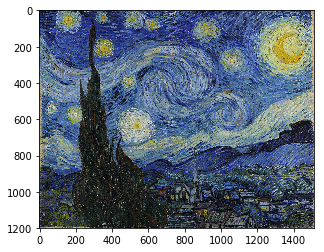

In [75]:
plt.imshow(style_img);

In [76]:
# resize style image to be same size as target image
def scale_match(src, targ):
    h,w,_ = src.shape
    sh,sw,_ = targ.shape
    rat = max(h/sh,w/sw); rat
    res = cv2.resize(targ, (int(sw*rat), int(sh*rat)))
    return res[:h,:w]

In [77]:
style = scale_match(img, style_img)

((291, 483, 3), (291, 483, 3))

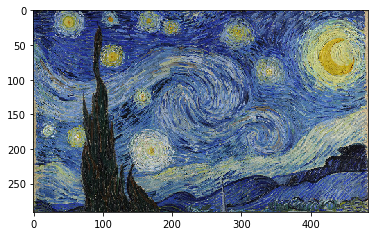

In [78]:
plt.imshow(style)
style.shape, img.shape

In [79]:
opt_img_v, optimizer = get_opt()

In [80]:
# save features for all block_ends -> array of activation layers
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [81]:
m_vgg(VV(img_tfm[None]))
targ_vs = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_vs]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [82]:
# transform style image
style_tfm = val_tfms(style_img)

In [83]:
# style image layers
m_vgg(VV(style_tfm[None]))
# pass through VGG and get array of activations at each layer
targ_styles = [V(o.features.clone()) for o in sfs]  # calling clone to keep a copy (change next time vgg() is called)
[o.shape for o in targ_styles]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [84]:
def gram(input):
        b,c,h,w = input.size()
        x = input.view(b*c, -1) # flatten batch (1) and channel, height X width
        return torch.mm(x, x.t())/input.numel()*1e6
        # matrix multiply w/ transpose
        # normalize by dividing by number of elements (b*c*h*w)
        # results in a tiny number so we multiply by a big number (1e6) to make it more sensible

def gram_mse_loss(input, target): return F.mse_loss(gram(input), gram(target))

In [85]:
def style_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]  # noise image layers
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]  # calc loss at each layer
    return sum(losses)  # add up layers; can do whatever you like really... (subsets, different weightings, etc.)

In [65]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,style_loss))

Iteration: n_iter, loss: 230718.453125
Iteration: n_iter, loss: 219493.21875
Iteration: n_iter, loss: 202618.109375
Iteration: n_iter, loss: 481.5616760253906
Iteration: n_iter, loss: 147.41177368164062
Iteration: n_iter, loss: 80.62625122070312
Iteration: n_iter, loss: 49.52326965332031
Iteration: n_iter, loss: 32.36254119873047
Iteration: n_iter, loss: 21.831811904907227
Iteration: n_iter, loss: 15.61091423034668


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


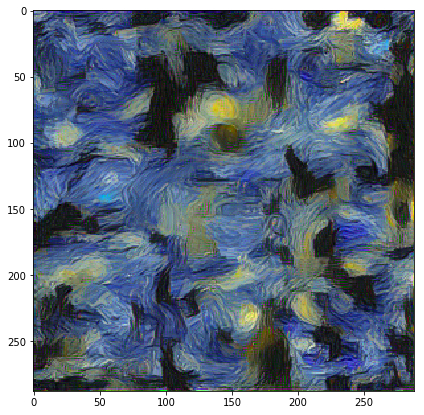

In [59]:
# random image in the style of Van Gogh

x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x);

In [68]:
for sf in sfs: sf.close()  # close out the hook to save memory 

## Style transfer

**Content Loss + Style Loss * lambda(some weight)**

In [86]:
opt_img_v, optimizer = get_opt()

In [87]:
def comb_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]  # content loss
    cnt_loss   = F.mse_loss(outs[3], targ_vs[3])*1000000              # style losses w/ multiplier
    style_loss = sum(losses)
    return cnt_loss + style_loss                                      # losses added together

In [88]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,comb_loss))

Iteration: n_iter, loss: 1802.36767578125
Iteration: n_iter, loss: 1163.05908203125
Iteration: n_iter, loss: 961.6024169921875
Iteration: n_iter, loss: 853.079833984375
Iteration: n_iter, loss: 784.970458984375
Iteration: n_iter, loss: 739.18994140625
Iteration: n_iter, loss: 706.310791015625
Iteration: n_iter, loss: 681.6689453125
Iteration: n_iter, loss: 662.4088134765625
Iteration: n_iter, loss: 646.329833984375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


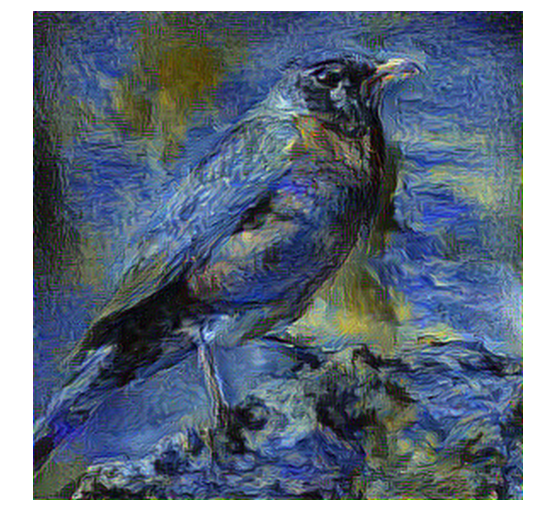

In [69]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(9,9))
plt.imshow(x, interpolation='lanczos')
plt.axis('off');

In [90]:
for sf in sfs: sf.close()

Solving a problem with a NN is as simple as coming up with a loss function and then optimizing (lowering) it!  

Deep Painterly Harmonization paper - https://arxiv.org/pdf/1804.03189.pdf  
Uses similar techniques to blend pasted images onto base images (captain america shield in ancient greek painting)